In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/My Drive/HSE_DL_2022/week_04

/content/gdrive/My Drive/HSE_DL_2022/week_04


# Наша первая свёрточная нейросеть 

Пришло время построить нашу первую свёрточную нейросеть.

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.__version__

'1.12.1+cu113'

In [4]:
import numpy as np
import random
from tqdm import tqdm
import seaborn as sns
sns.set_context('talk')

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Смотрим на данные 

Скачаеми приготовим данные. Буквально через минуту в наших руках окажутся $60 000$ картинок размера $28 \times 28$.

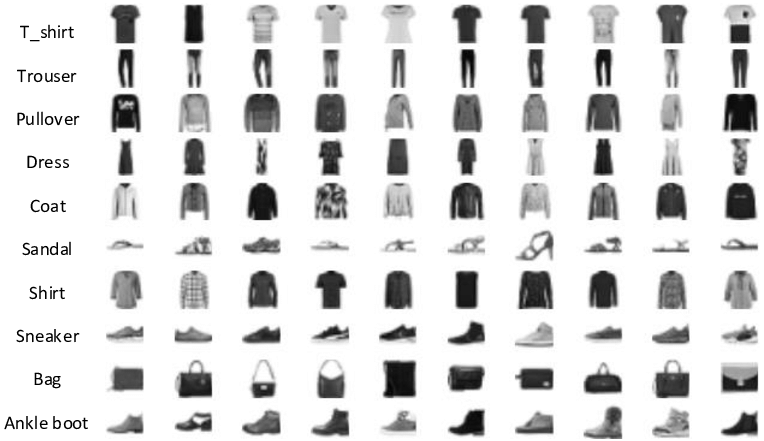

In [6]:
from IPython import display
display.Image(open('images/Fashion-MNIST-dataset.png', 'rb').read())

In [5]:
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, 
                                             download=True, 
                                             transform=transforms.ToTensor())
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, 
                                            download=True, 
                                            transform=transforms.ToTensor())

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [7]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

<class 'torchvision.datasets.mnist.FashionMNIST'>
torch.Size([1, 28, 28])


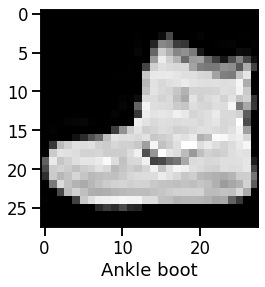

In [8]:
print(type(trainset))
print(trainset[0][0].shape)

plt.grid(False)
plt.imshow(trainset[0][0].squeeze(), cmap = 'gray')
plt.xlabel(class_names[trainset[0][1]])
plt.show()

Нарисуем несколько рандомных картинок из тренировочной выборки. 

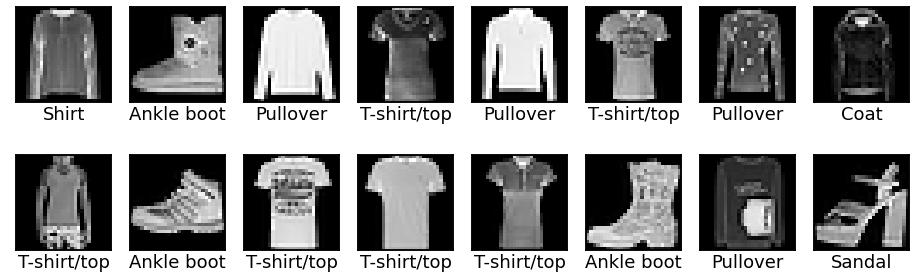

In [9]:
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols, 2.5 * rows))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(trainset))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(trainset[random_index][0].squeeze(), cmap = 'gray')
        ax.set_xlabel(class_names[trainset[random_index][1]])
plt.show()

## 2.  Выбираем для нашей нейросети архитектуру

Свёрточная нейронная сеть строится из нескольких разных типов слоёв: 

* [Conv2D](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) - Конволюция
* [MaxPooling2D](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveMaxPool2d.html?highlight=maxpool#torch.nn.AdaptiveMaxPool2d) - макспулинг
* [Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html?highlight=flatten#torch.nn.Flatten) - разворачивает картинку в вектор 
* [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=nn%20linear#torch.nn.Linear) - полносвязный слой (fully-connected layer)
* [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html?highlight=nn%20relu#torch.nn.ReLU) - функция активации
* [LeakyReLU](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html?highlight=leaky#torch.nn.LeakyReLU) - leaky relu активация
* [Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html?highlight=nn%20dropout#torch.nn.Dropout) - дропаут.


В модели, которую мы определим ниже, на вход будет идти тензоры размера __(None, 28, 28, 1)__ и __(None, 10)__. На выходе мы будем получать вероятноть того, что объект относится к конкретному классу. Разменость __None__ заготовлена для размерности батча. 

## 2.1 Полносвязная сетка 

Соберём полносвязную сеть

**Важный момент:** после последнего FC слоя `softmax` не вызывается, т.к. он заложен внутрь [`nn.CrossEntropyLoss()`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)

In [10]:
RANDOM_SEED = 1234
torch.manual_seed(RANDOM_SEED)

In [11]:
class FC(nn.Module):
    def __init__(self): 
        super().__init__()
        self.classifier = nn.Sequential(nn.Linear(784, 64),  # 28 x 28 = 784
                                        nn.BatchNorm1d(64),
                                        nn.ReLU(),
                                        nn.Linear(64, 32),
                                        nn.BatchNorm1d(32),
                                        nn.ReLU(),
                                        nn.Linear(32, 16),
                                        nn.BatchNorm1d(16),
                                        nn.ReLU(),
                                        nn.Linear(16, 10),
                                    )
             
    def forward(self, x):
        x = x.reshape(x.size(0), -1)
        logits = self.classifier(x)
        # probs = F.softmax(logits, dim=1) # if no dim is given, then a warning will appear
        return logits

In [12]:
batch_size = 512
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [13]:
trainset.data.shape

torch.Size([60000, 28, 28])

In [14]:
print(iter(trainloader).next()[0].shape)

torch.Size([512, 1, 28, 28])


In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model_fc = FC()
model_fc.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(model_fc.parameters(), lr=0.01)

cuda


In [16]:
def train_nn(trainloader, model, opt, loss_fn, device):
    running_loss = []

    model.train()
    correct_pred = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)

        opt.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs.cpu(), labels)
        loss.backward()
        opt.step()

        correct_pred += (outputs.cpu().argmax(dim=1) == labels).sum()
        
        running_loss.append(loss.item())

    return model, running_loss, correct_pred


def eval_nn(testloader, model, loss_fn, device):
    running_loss_test = []

    model.eval()
    correct_pred = 0
    predicts = np.array([])
    for i, data in enumerate(testloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)

        outputs = model(inputs)
        predicts = np.append(predicts, outputs.cpu().argmax(dim=1).numpy())
        loss = loss_fn(outputs.cpu(), labels)

        correct_pred += (outputs.cpu().argmax(dim=1) == labels).sum()

        running_loss_test.append(loss.item())
    return running_loss_test, predicts.astype(int), correct_pred

In [17]:
len(trainloader.dataset), len(testloader.dataset)

(60000, 10000)

In [18]:
def training_loop(model, trainloader, testloader, opt, loss_fn, device, max_epochs=20):
    len_train = len(trainloader.dataset)
    len_test = len(testloader.dataset)

    loss_arr = []
    loss_arr_test = []
    acc = []
    acc_test = []

    for epoch in range(max_epochs):        
        model, running_loss, correct_pred = train_nn(trainloader, model, opt, loss_fn, device)
        running_loss_test, _, correct_pred_test = eval_nn(testloader, model, loss_fn, device)

        loss_arr.append(np.mean(running_loss))
        loss_arr_test.append(np.mean(running_loss_test))
        
        acc.append(correct_pred / len_train)
        acc_test.append(correct_pred_test / len_test)

        if epoch % 4 == 0:
            print(f'Epoch: {epoch}\t'
                  f'Train loss: {loss_arr[-1]:.5f}\t'
                  f'Test loss: {loss_arr_test[-1]:.5f}\t'
                  f'Train accuracy: {100 * acc[-1]:.2f}\t'
                  f'Valid accuracy: {100 * acc_test[-1]:.2f}')
            # print(f'EPOCH {epoch},  train_loss: {loss_arr[-1]:.5f} test_loss: {loss_arr_test[-1]:.5f}')

    return loss_arr, loss_arr_test, acc, acc_test


def plot(loss_arr, loss_arr_test, acc, acc_test):
    fig, ax = plt.subplots(1, 2, figsize=(20, 6))

    ax[0].plot(loss_arr, label='Train loss')
    ax[0].plot(loss_arr_test, label='Validation loss')
    ax[0].legend()
    ax[0].grid()

    ax[1].plot(acc, label='Train accuracy')
    ax[1].plot(acc_test, label='Validation accuracy')
    ax[1].legend()
    ax[1].grid();

In [19]:
loss_arr, loss_arr_test, acc, acc_test = training_loop(model_fc, trainloader, testloader, opt, loss_fn, device, max_epochs=20)

Epoch: 0	Train loss: 1.74166	Test loss: 1.44557	Train accuracy: 49.96	Valid accuracy: 61.93
Epoch: 4	Train loss: 0.69488	Test loss: 0.68025	Train accuracy: 82.86	Valid accuracy: 81.80
Epoch: 8	Train loss: 0.47498	Test loss: 0.51391	Train accuracy: 86.35	Valid accuracy: 84.22
Epoch: 12	Train loss: 0.38844	Test loss: 0.45227	Train accuracy: 87.97	Valid accuracy: 84.71
Epoch: 16	Train loss: 0.34391	Test loss: 0.42888	Train accuracy: 88.81	Valid accuracy: 85.48


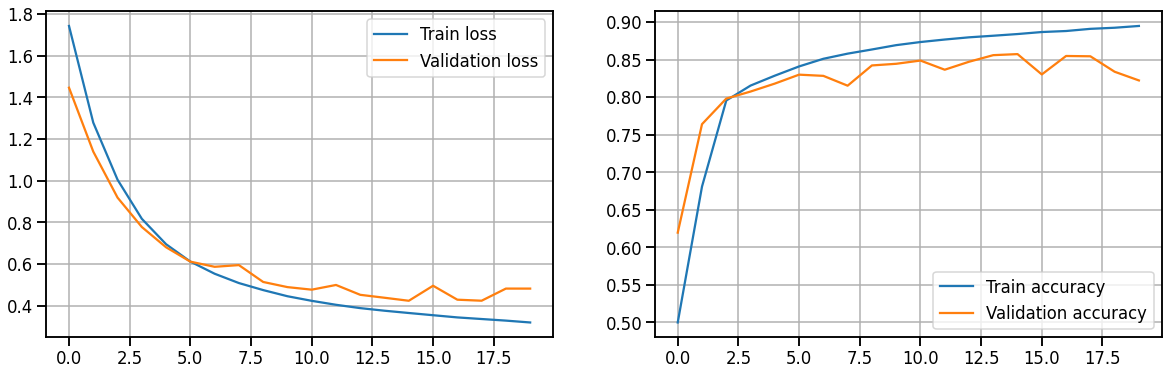

In [20]:
plot(loss_arr, loss_arr_test, acc, acc_test)

In [21]:
print("Loss: ", loss_arr_test[-1])

Loss:  0.48211484849452974


Можно посмотреть, где именно сетка ошибается. 

In [22]:
sns.set_context('notebook')

In [23]:
_, y_pred, _ = eval_nn(testloader, model_fc, loss_fn, device)
X_test = testset.data.numpy()
y_test = testset.targets.numpy()

errors = (y_pred != y_test)

# срежем только наблюдения, где была ошибка
X_err = X_test[errors]
y_err = y_test[errors]
y_pred = y_pred[errors]

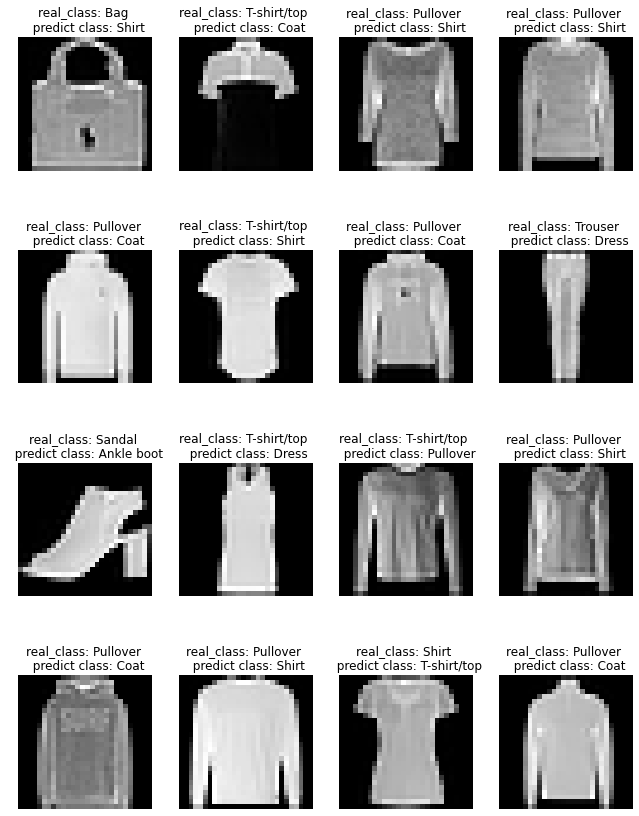

In [24]:
def plot_failure_predictions(X_err, y_err, y_pred, cols=4, rows=4):
    fig = plt.figure(figsize=(3 * cols - 1, 4 * rows - 1))
    for i in range(cols):
        for j in range(rows):
            random_index = np.random.randint(0, len(y_err))
            ax = fig.add_subplot(rows, cols, i * rows + j + 1)
            ax.grid('off')
            ax.axis('off')
            ax.imshow(X_err[random_index, : ], cmap='gray')
            ax.set_title('real_class: {} \n  predict class: {}'.format(class_names[y_err[random_index]], 
                                                                    class_names[y_pred[random_index]]))
    plt.show()

plot_failure_predictions(X_err, y_err, y_pred)

## 2.2 Свёрточная сетка 

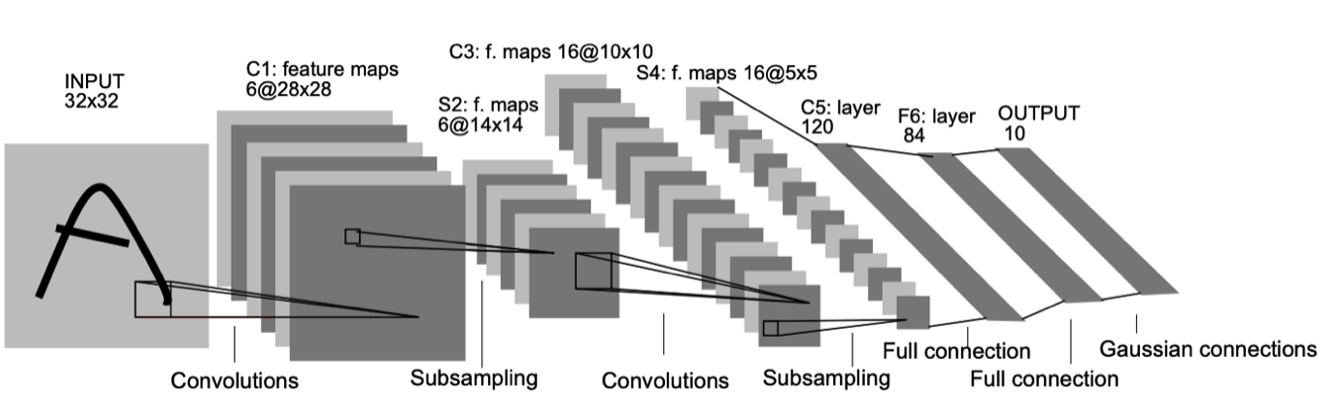

In [25]:
display.Image('images/lenet.png', retina=True)

Также стоит держать в голове формулы для рассчета размера выхода после \
**Convolutional и Max/Avg pooling слоев:**
$$\dfrac{W−F+2P}{S}+1$$

- W is the input height/width (normally the images are squares, so there is no need to differentiate the two)
- F is the filter/kernel size
- P is the padding
- S is the stride

Теперь давайте соберём свёртоную сеть: 

* Свёртка с ядром $5 \times 5$ и $6$ каналами
* Tanh
* Avgpooling размера $2 \times 2$ с шагом (strides) $2$ по обеим осям
* Свёртка с ядром $5 \times 5$ и $16$ каналами
* Tanh
* Avgpooling размера $2 \times 2$ с шагом (strides) $2$ по обеим осям 
* Свёртка с ядром $4 \times 4$ и $120$ каналами
* Дальше сделайте `Flatten` и сделайте два полносвязных слоя с ReLU и $120$ и $84$ нейронами

Хорошая [статья](https://towardsdatascience.com/implementing-yann-lecuns-lenet-5-in-pytorch-5e05a0911320) о том, как писать такую сетку на PyTorch

In [26]:
# 
#  Ваша LeNet сетка
#  

class CNN(nn.Module):
    def __init__(self): 
        super().__init__()
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1), # (28-5+0)/1+1 = 24
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2), # (24-2+0)/2+1 = 12
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1), # (12-5+0)/1+1 = 8
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2), # (8-2+0)/2+1 = 4
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=4, stride=1), # (4-4+0)/1+1 = 1
            nn.Tanh())

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=10))

    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.reshape(x.size(0), -1)
        logits = self.classifier(x)
        return logits

In [27]:
%%time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model_cnn = CNN()
model_cnn.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(model_cnn.parameters(), lr=0.001)

loss_arr, loss_arr_test, acc, acc_test = training_loop(model_cnn, trainloader, testloader, opt, loss_fn, device, max_epochs=35)

cuda
Epoch: 0	Train loss: 1.10147	Test loss: 0.70849	Train accuracy: 61.63	Valid accuracy: 72.61
Epoch: 4	Train loss: 0.45765	Test loss: 0.48015	Train accuracy: 82.96	Valid accuracy: 81.78
Epoch: 8	Train loss: 0.37920	Test loss: 0.40191	Train accuracy: 86.12	Valid accuracy: 85.45
Epoch: 12	Train loss: 0.33655	Test loss: 0.37334	Train accuracy: 87.57	Valid accuracy: 86.09
Epoch: 16	Train loss: 0.30897	Test loss: 0.35451	Train accuracy: 88.73	Valid accuracy: 86.71
Epoch: 20	Train loss: 0.28539	Test loss: 0.33218	Train accuracy: 89.58	Valid accuracy: 87.98
Epoch: 24	Train loss: 0.27008	Test loss: 0.32135	Train accuracy: 90.11	Valid accuracy: 88.44
Epoch: 28	Train loss: 0.25604	Test loss: 0.32315	Train accuracy: 90.53	Valid accuracy: 88.21
Epoch: 32	Train loss: 0.24128	Test loss: 0.31315	Train accuracy: 91.07	Valid accuracy: 88.69
CPU times: user 3min 22s, sys: 1.28 s, total: 3min 23s
Wall time: 3min 26s


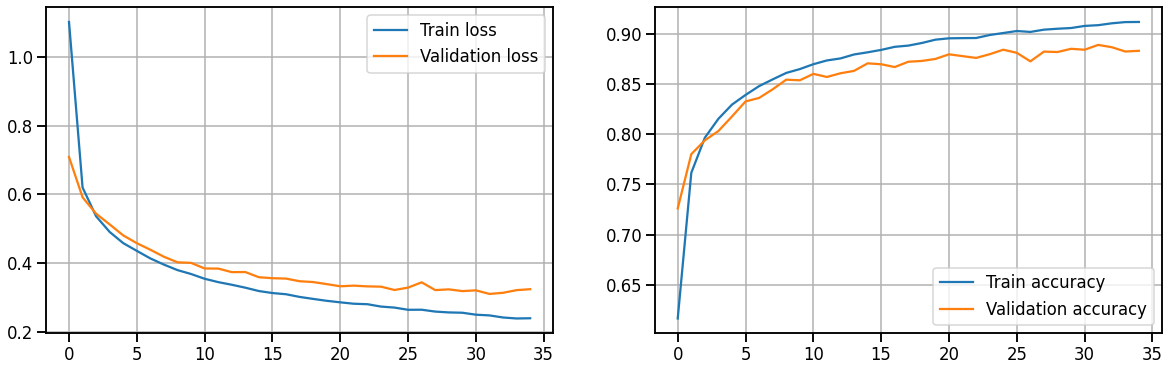

In [28]:
sns.set_context('talk')
plot(loss_arr, loss_arr_test, acc, acc_test)

In [29]:
print("Loss: ", loss_arr_test[-1])

Loss:  0.3236620709300041


Посмотрим на каких примерах сверточная сеть ошибается

In [30]:
_, y_pred, _ = eval_nn(testloader, model_cnn, loss_fn, device)
X_test = testset.data.numpy()
y_test = testset.targets.numpy()

errors = (y_pred != y_test)

# срежем только наблюдения, где была ошибка
X_err = X_test[errors]
y_err = y_test[errors]
y_pred = y_pred[errors]

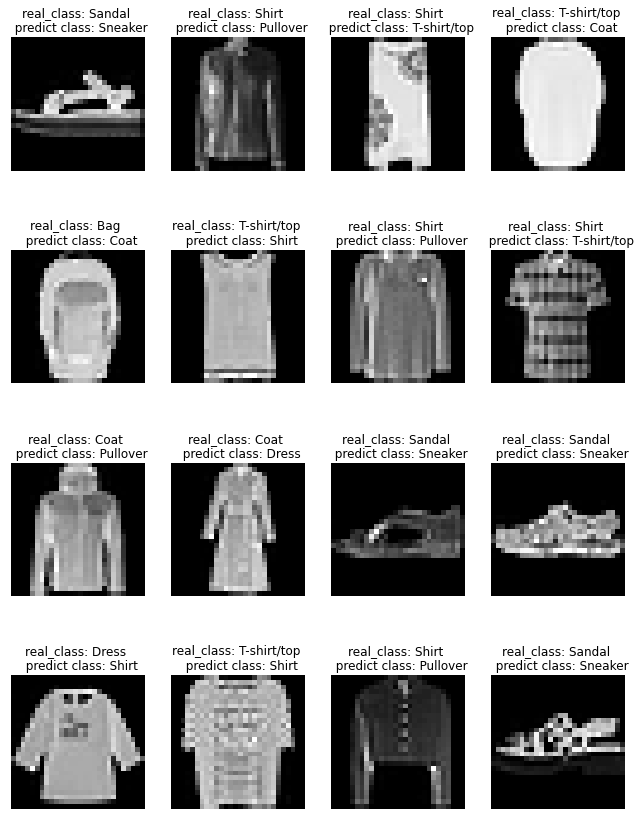

In [31]:
sns.set_context('notebook')
plot_failure_predictions(X_err, y_err, y_pred)

## Data Augmentation

Если обучить нейронку с использованием этих настроек, она никогда не увидит одно и то же изображение дважды. Однако входные данные по-прежнему будут довольно сильно связаны между собой. Мы пытаемся исказить уже существующие объекты так, чтобы они всё ещё оставались собой, но нейронка не выучивала детали, присущие конкретным наблюдениям, то есть не переобучалась.

Интересная [статья](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py) из документации PyTorch на тему визуализации transformations

In [32]:
train_tfms = transforms.Compose([#transforms.RandomCrop(28), 
                                 transforms.RandomHorizontalFlip(), 
                                 transforms.RandomRotation(degrees=(0, 90)),
                                #  transforms.RandomResizedCrop(28), 
                                #  transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                                 transforms.ToTensor()])
valid_tfms = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, 
                                             download=True, 
                                             transform=train_tfms)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, 
                                            download=True, 
                                            transform=valid_tfms)

batch_size = 512
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

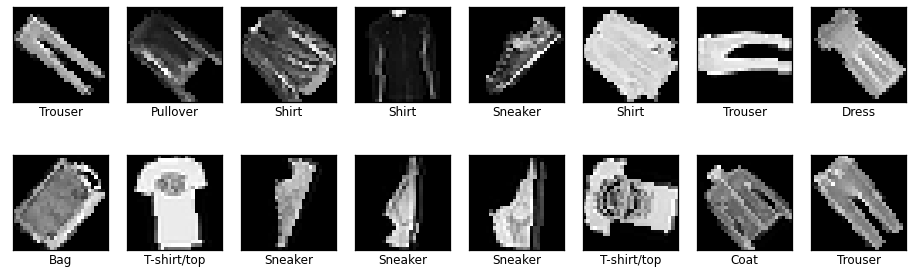

In [33]:
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols, 2.5 * rows))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(trainset))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(trainset[random_index][0].squeeze(), cmap = 'gray')
        ax.set_xlabel(class_names[trainset[random_index][1]])
plt.show()

Обучим сетку из предыдущего пункта на новых (аугментированных) данных.

In [ ]:
%%time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model_cnn = CNN()
model_cnn.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(model_cnn.parameters(), lr=0.001)

loss_arr, loss_arr_test, acc, acc_test = training_loop(model_cnn, trainloader, testloader, opt, loss_fn, device, max_epochs=55)

cuda
Epoch: 0	Train loss: 1.38149	Test loss: 1.21875	Train accuracy: 50.96	Valid accuracy: 55.67
Epoch: 4	Train loss: 0.67064	Test loss: 0.88936	Train accuracy: 74.36	Valid accuracy: 67.80
Epoch: 8	Train loss: 0.56170	Test loss: 0.77306	Train accuracy: 79.04	Valid accuracy: 71.47
Epoch: 12	Train loss: 0.50590	Test loss: 0.64391	Train accuracy: 81.37	Valid accuracy: 76.63
Epoch: 16	Train loss: 0.47805	Test loss: 0.65197	Train accuracy: 82.27	Valid accuracy: 76.97
Epoch: 20	Train loss: 0.45265	Test loss: 0.63919	Train accuracy: 83.27	Valid accuracy: 77.17
Epoch: 24	Train loss: 0.43243	Test loss: 0.57572	Train accuracy: 83.95	Valid accuracy: 79.47
Epoch: 28	Train loss: 0.42084	Test loss: 0.55903	Train accuracy: 84.39	Valid accuracy: 79.62
Epoch: 32	Train loss: 0.41043	Test loss: 0.57222	Train accuracy: 84.76	Valid accuracy: 80.09
Epoch: 36	Train loss: 0.39529	Test loss: 0.51913	Train accuracy: 85.22	Valid accuracy: 81.27
Epoch: 40	Train loss: 0.39212	Test loss: 0.52965	Train accuracy: 85.

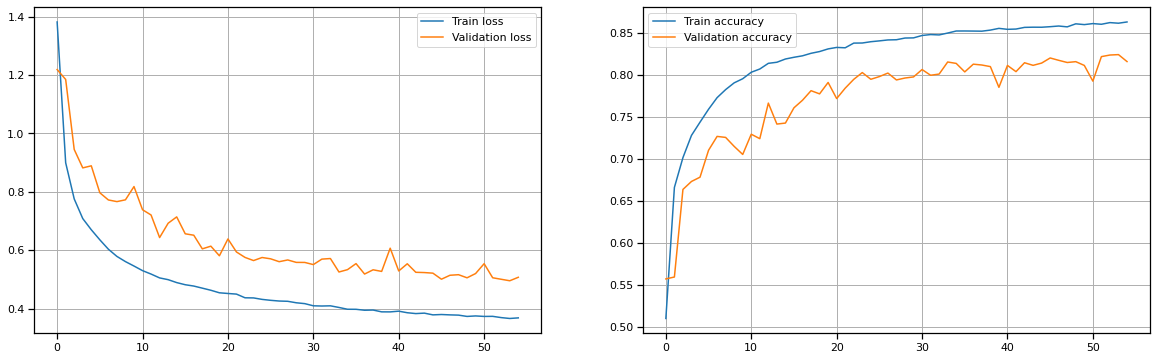

In [ ]:
sns.set_context('talk')
plot(loss_arr, loss_arr_test, acc, acc_test)

Такую сетку надо учить подольше. В этой тетрадке она реализована просто как пример аугментации данных. За реальное улучшение качества еще нужно побиться